# Training InfoMax representations

In this example we show how to use the `torch_mist` package to train InfoMax representations. For simplicity, we will use the `MNIST` dataset.

## Data loading
We start by defining a dataset and data-loader that returns pairs of augmented images.
Each data augmentation consists of random affine transformations within a specified range.

In [1]:
from typing import Callable
from torchvision.datasets import MNIST

# Simple wrapper to create pairs (x,y) of images
class PairedMNIST(MNIST):
    def __init__(self, root: str, transform: Callable, *args, **kwargs):
        super().__init__(root, *args, **kwargs)
        self._transform = transform
     
    def __getitem__(self, index: int):
        image, label = super().__getitem__(index)
        image_1 = self._transform(image)
        image_2 = self._transform(image)
        return {'x': image_1, 'y': image_2}

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from torchvision.transforms import ToTensor, Compose, RandomAffine
from torch.utils.data import DataLoader

data_root = '/data/MNIST' 
batch_size = 128
num_workers = 8

# Load the train set
train_set = PairedMNIST(
    data_root, 
    transform=Compose([
        # Each pair is created by applying random affine transformations
        RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.7, 1.1), shear=20), 
        ToTensor()
    ])
)

# A non-augmented test set and data loader
test_set = MNIST(data_root, train=False, transform=ToTensor())
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers
)

Text(0.5, 1.0, 'y')

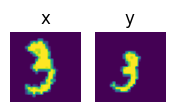

In [3]:
import matplotlib.pyplot as plt

# Visualize a pair of training images
data = train_set[10]
f, ax = plt.subplots(1,2, figsize=(2,4))

ax[0].imshow(data['x'].permute(1,2,0))
ax[0].axis('off')
ax[0].set_title('x')

ax[1].imshow(data['y'].permute(1,2,0))
ax[1].axis('off')
ax[1].set_title('y')

## Instantiating the Encoder

In this example, we are interested in learning a 2D InfoMax representation of the MNIST digits, for this reason, we define a simple convolutional encoder that will be used to map the images into 2D vectors.

In [4]:
from torch import nn

# Simple Convolutional Encoder 
z_dim = 2
encoder = nn.Sequential(
    nn.Conv2d(1, 64, 7, 2),
    nn.ReLU(True),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(True),
    nn.Conv2d(128, 128, 9),
    nn.ReLU(True),
    nn.Flatten(),
    nn.Linear(128, 64),
    nn.ReLU(True),
    nn.Linear(64, z_dim)
)

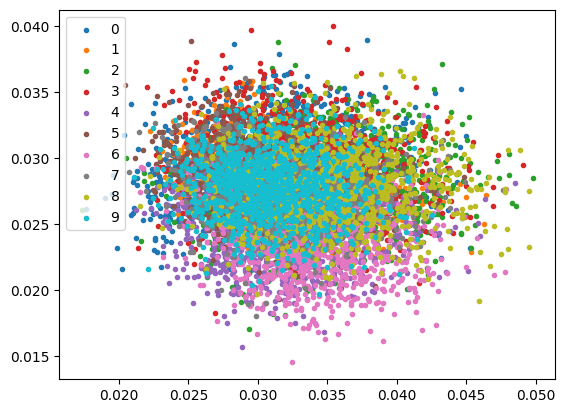

In [5]:
import torch

# Define a utility function to encode all the data
def encode_all(dataloader):
    zs = []
    labels = []
    for image, label in dataloader:
        z = encoder(image)
        zs.append(z)
        labels.append(label)
        
    zs = torch.cat(zs, 0).data.numpy()
    labels = torch.cat(labels, 0).data.numpy()
    return zs, labels

representations, labels = encode_all(test_loader)

# Plot the representation colored by true label
f, ax = plt.subplots(1,1)
for label in range(10):
    ax.scatter(representations[labels==label,0], representations[labels==label,1],marker='.', label=label)    
ax.legend()

## Defining the Mutual Information Estimator
We maximize mutual information using the Jensen-Shannon (JS) estimator, which is also known in literature as Deep-InfoMax.
Therefore, we first initialize the `JS` estimator specifying that both `x` and `y` are 2-dimensional (the two representations).

Since we are interested in training the encoders, we want to make sure that it is possible to backpropagate the gradient through `x` and `y`.
The estimators in the `torch_mist` package are equipped with an attribute `infomax_gradient`, which indicates if the estimator gives valid gradient for $\frac{\partial \tilde I(x,y)}{\partial x}$ and $\frac{\partial \tilde I(x,y)}{\partial y}$. 
$\tilde I(x,y)$ indicates the mutual information estimate. Note that some estimator provide valid gradients only for `x` (e.g. generative estimators).

In [6]:
from torch_mist.estimators import js

# We instantiate a simple JS estimator (DeepInfoMax) 
mi_estimator = js(
    x_dim=z_dim, y_dim=z_dim,
    hidden_dims=[64, 32],
    neg_samples=16,
)
# The JS estimator provides gradient with respect to both inputs, therefore we can optimize the encoders
# together with the estimator
print('InfoMax gradient:', mi_estimator.infomax_gradient)


InfoMax gradient: {'x': True, 'y': True}


Secondly, we compound the encoder and the `JS` estimator by using the `TransformedMIEstimator` class.
Here we specify that we are applying the encoder to the original $x$ and $y$ (images) to map them into the corresponding representations (which are still refered to as $x$ and $y$). 

In [7]:
from torch_mist.estimators import TransformedMIEstimator

# We apply the encoder to x and y before feeding it to the estimator
mi_estimator = TransformedMIEstimator(
    transforms={'x': encoder, 'y': encoder},
    base_estimator=mi_estimator
)

## Training the estimator
Lastly, we can train the mutual information estimator (including both the `encoder` and the `JS` parameters) using the `train_mi_estimator` utility.

In [8]:
from torch_mist.utils.train import train_mi_estimator

# Train the mutual information estimator for 10 epochs on cpu
train_log = train_mi_estimator(
    mi_estimator,
    data=train_set,
    lr_annealing=False,
    max_epochs=10,
    device='cpu',
    batch_size=128
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/422 [00:00<?, ?it/s]

## Results and visualizations

The training utility returns a `pandas.DataFrame` containing the loss and mutual information estimates over time.

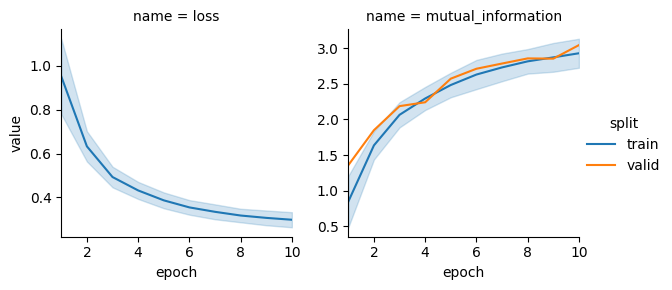

In [21]:
import seaborn as sns

# Plot loss and mutual information over time
grid = sns.FacetGrid(train_log, col='name', hue='split', sharey=False, sharex=True, xlim=(1,10))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.add_legend()

Lastly, we visualize the representations colored by label to show a significant level of structure and separation when compared to the randomly initialized architectures. 

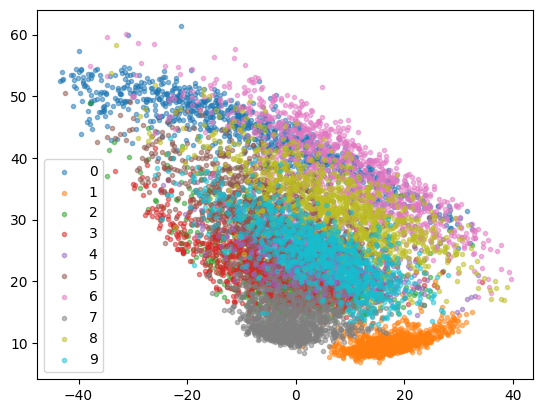

In [18]:
representations, labels = encode_all(test_loader)

# Plot the trained representation colored by true label
f, ax = plt.subplots(1,1)
for label in range(10):
    ax.scatter(representations[labels==label,0], representations[labels==label,1],marker='.', label=label, alpha=0.5)    
ax.legend()